In [3]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *

In [4]:
ts2 = msprime.sim_ancestry(3, population_size=100, sequence_length=1e5, recombination_rate=1e-8,
                         record_full_arg=True)

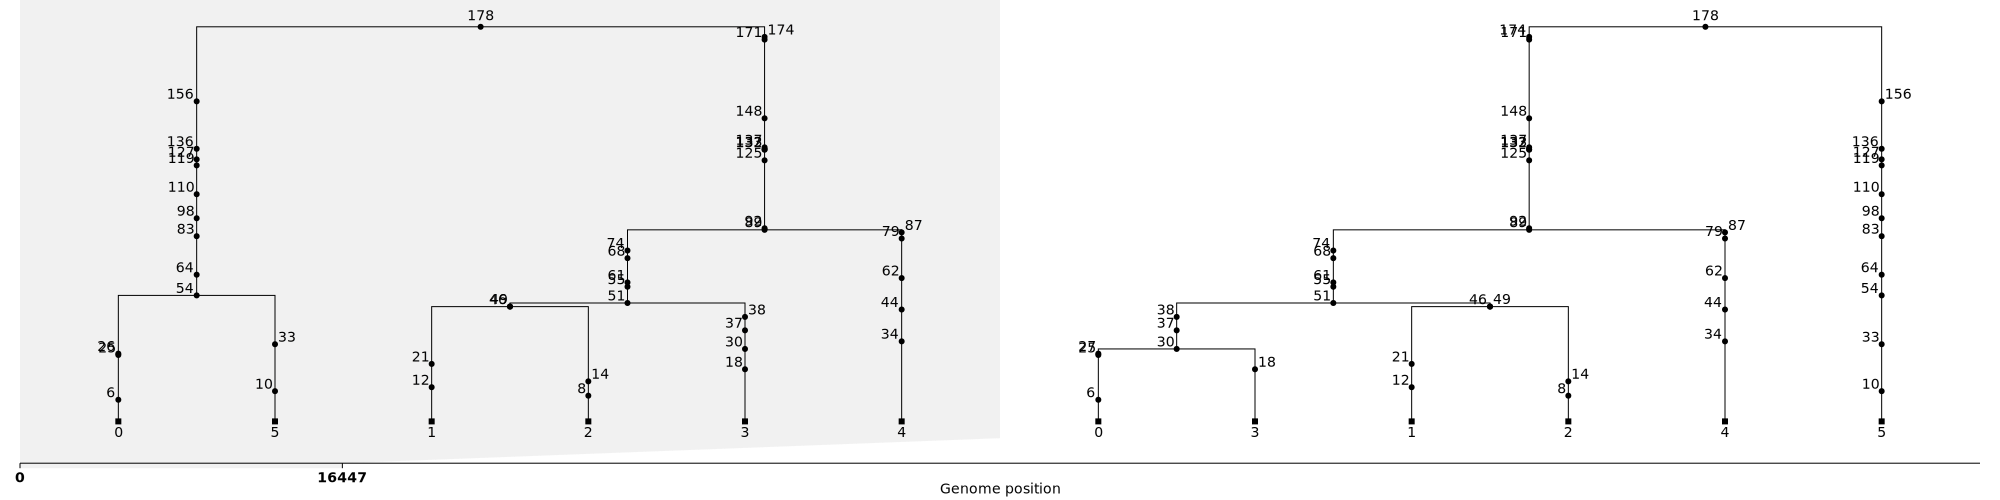

In [14]:
SVG(ts2.draw_svg(size=(2000, 500), x_lim=[0, 1e5]))

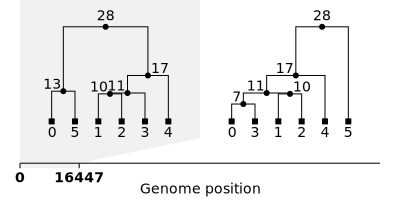

In [15]:
sts = ts2.simplify()
SVG(sts.draw_svg(x_lim=[0, 1e5]))

[231, 182, 170, 168]


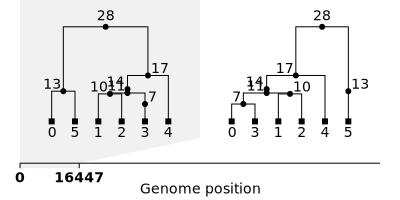

In [16]:
ts1, n = extend_edges(sts)
print(n)
SVG(ts1.draw_svg(x_lim=[0, 1e5]))

Our goal is to construct a function to measure the number of discrepancies between our inferred tree sequence $TS_1$ and the ground truth $TS_2$. For tree sequences $TS_1$ and $TS_2$ both of sequence length $L$, each have nodes at position $i$ in the genome, $x$ and $y$ respectively. From these nodes we count the number of samples which stem from them. We define these sets as $D_1(i,x)$ and $D_2(i,y)$. We count the number of descrepancies between the nodes $x$ and $y$ as their set difference, $|D_1(i,x)\vartriangle D_2(i,y)|$. We define the $\textbf{discrepancy number}$ between nodes $x$ and $y$ as 
$$ d(x,y) = \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|. $$
Using this we generalize to find the number of discrepancies between a node $x$ and the ground truth $TS_2$,
$$ d(x,TS_2) = \inf_{y\in TS_2.nodes()} d(x,y).$$
Finally, to compute the number of discrepancies between tree sequences we use the function
$$d(TS_1,TS_2) = \sum_{x\in TS_1.nodes()} d(x,TS_2)=\sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} d(x,y) = \sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|,$$
and call this the $\textbf{discrepancy number}$ between $TS_1$ and $TS_2$.

In [38]:
''' I believe here we do have to specify which tree sequence each node comes from. I could not find a function to do so
so instead I just added each nodes repecitive tree sequence as an argument. '''

def node_discrepancy(x,ts1,y,ts2): # function to return the discrepancy number between two nodes, d(x,y)
    dis = 0
    for i in range(int(ts1.sequence_length)):
        tree1 = ts1.at(i)
        tree2 = ts2.at(i)
        Dx = {}
        Dy = {}
        
        for s1, s2 in zip(tree1.samples(x), tree2.samples(y)): 'I get an error here and I am not sure how to fix this (SEE BELOW)'
            Dx.add(s1)
            Dy.add(s2)
        dxy = Dx.symmetric_difference(Dy)
        dis += len(dxy)
    return dis

def node_tree_discrepancy(x, ts1, ts2): # function to return the discrepancy number between a node and tree sequence d(x,TS2)
    dmin = 0
    dis = []
    for y in ts2.nodes():
        dis.append(node_discrepancy(x,ts1,y,ts2))
    d = np.array(dis)
    dmin = np.amin(d)
    
    return dmin # Perhaps we could also have this function also return a list of the nodes which give us the minimal discrepancy number

In [28]:
def discrepancy(ts1, ts2):
    assert ts1.num_trees == ts2.num_trees, "Must have same number of trees between tree sequences."
    dis = 0
    
    for n in ts1.nodes():
        dis += node_tree_discrepancy(n,ts1,ts2) 
    
    return dis

In [65]:
test_node1 = ts1.node(7)
test_node2 = ts2.node(52)
test_tree1 = ts1.at(1000)
test_tree2 = ts2.at(1000)
test_tree1.samples(test_node1)

<generator object Tree.samples at 0x000002439D78CA50>

In [66]:
testset = {s for s in test_tree1.samples(test_node1)} # I dont know how to resolve this error
'I am guessing that this error might occur when the tree does not contain the node and so the generator is empty maybe?'

TypeError: an integer is required (got type Node)